In [611]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols

**Project Goal:** The goal of this project is to study if we can predict per capita income in a county from the data on fresh markets in the county.

Let's create separate dataframes for data from the two csv file.

In [612]:
df_FM1=pd.read_csv('farmers_markets_from_usda.csv')   #initial dataframe with data on farmer's market.

In [613]:
df_FM1.head(2)

,FMID,MarketName,Website,Facebook,Twitter,Youtube,OtherMedia,street,city,County,...,Coffee,Beans,Fruits,Grains,Juices,Mushrooms,PetFood,Tofu,WildHarvested,updateTime
0,1018261,Caledonia Farmers Market Association - Danville,https://sites.google.com/site/caledoniafarmers...,https://www.facebook.com/Danville.VT.Farmers.M...,NaN,NaN,NaN,NaN,Danville,Caledonia,...,Y,Y,Y,N,N,Y,Y,N,N,6/20/2017 22:43
1,1018318,Stearns Homestead Farmers' Market,http://www.StearnsHomestead.com,StearnsHomesteadFarmersMarket,NaN,NaN,NaN,6975 Ridge Road,Parma,Cuyahoga,...,N,N,Y,N,N,N,N,N,N,6/21/2017 17:15


In [614]:
df_county=pd.read_csv('datasets_706231_1233065_wiki_county_info.csv')      #initial dataframe with county information.

In [615]:
df_county.head(2)

,number,county,State,per capita income,median household income,median family income,population,number of households
0,1,New York County,New York,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,2,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454"


Since the demographic data is given by county, let's sort and group data by county and merge the two dataframes. This will make data analysis and machine learning easier.

In [616]:
df_county_count=pd.DataFrame(df_FM1['County'].value_counts())

In [617]:
df_county_count.rename(columns={'County':'County_Count'},inplace=True)

In [618]:
df_county_count.head()

,County_Count
Los Angeles,128
Cook,111
Jefferson,100
Washington,93
Franklin,87


In [619]:
df_FM1.columns.values

array(['FMID', 'MarketName', 'Website', 'Facebook', 'Twitter', 'Youtube',
       'OtherMedia', 'street', 'city', 'County', 'State', 'zip',
       'Season1Date', 'Season1Time', 'Season2Date', 'Season2Time',
       'Season3Date', 'Season3Time', 'Season4Date', 'Season4Time', 'x',
       'y', 'Location', 'Credit', 'WIC', 'WICcash', 'SFMNP', 'SNAP',
       'Organic', 'Bakedgoods', 'Cheese', 'Crafts', 'Flowers', 'Eggs',
       'Seafood', 'Herbs', 'Vegetables', 'Honey', 'Jams', 'Maple', 'Meat',
       'Nursery', 'Nuts', 'Plants', 'Poultry', 'Prepared', 'Soap',
       'Trees', 'Wine', 'Coffee', 'Beans', 'Fruits', 'Grains', 'Juices',
       'Mushrooms', 'PetFood', 'Tofu', 'WildHarvested', 'updateTime'],
      dtype=object)

In [620]:
df_FM1=df_FM1[['FMID', 'Website', 'city', 'County', 'State', 'zip', 'x', 'y', 'Location','Credit', 'WIC', 'WICcash', 'SFMNP', 'SNAP', 'Organic', 'Bakedgoods', 'Cheese', 'Crafts', 'Flowers', 'Eggs', 'Seafood','Herbs', 'Vegetables', 'Honey', 'Jams', 'Maple', 'Meat', 'Nursery','Nuts', 'Plants', 'Poultry', 'Prepared', 'Soap', 'Trees', 'Wine','Coffee', 'Beans', 'Fruits', 'Grains', 'Juices', 'Mushrooms','PetFood', 'Tofu', 'WildHarvested']].copy(deep=True)

In [621]:
df_FM1.head(20)

,FMID,Website,city,County,State,zip,x,y,Location,Credit,...,Wine,Coffee,Beans,Fruits,Grains,Juices,Mushrooms,PetFood,Tofu,WildHarvested
0,1018261,https://sites.google.com/site/caledoniafarmers...,Danville,Caledonia,Vermont,5828,-72.140335,44.411037,NaN,Y,...,N,Y,Y,Y,N,N,Y,Y,N,N
1,1018318,http://www.StearnsHomestead.com,Parma,Cuyahoga,Ohio,NaN,-81.733940,41.374802,NaN,Y,...,N,N,N,Y,N,N,N,N,N,N
2,1009364,http://thetownofsixmile.wordpress.com/,Six Mile,Pickens,South Carolina,29682,-82.818703,34.804199,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1010691,NaN,Lamar,Barton,Missouri,64759,-94.274620,37.495628,NaN,Y,...,N,N,N,Y,N,N,N,N,N,N
4,1002454,NaN,New York,New York,New York,10029,-73.949303,40.793900,Private business parking lot,N,...,N,N,N,N,N,N,N,N,N,N
5,1011100,http://www.12southfarmersmarket.com,Nashville,Davidson,Tennessee,37204,-86.790710,36.118370,NaN,Y,...,N,Y,N,Y,N,Y,Y,Y,N,N
6,1009845,http://www.125thStreetFarmersMarket.com,New York,New York,New York,10027,-73.948250,40.808952,Federal/State government building grounds,Y,...,Y,Y,N,Y,N,Y,N,N,N,N
7,1005586,NaN,Wilmington,New Castle,Delaware,19801,-75.534462,39.742119,"On a farm from: a barn, a greenhouse, a tent, ...",N,...,N,N,N,Y,N,N,N,N,N,N
8,1008071,NaN,Washington,District of Columbia,District of Columbia,20009,-77.032051,38.917000,Other,Y,...,N,N,Y,Y,Y,Y,N,N,N,N
9,1012710,NaN,Washington,District of Columbia,District of Columbia,20011,-77.033447,38.955978,NaN,Y,...,N,Y,N,Y,N,N,N,Y,N,N


In [622]:
df_FM1['website_count']=df_FM1['Website'].notnull().astype(int)
df_FM1['OrganicYN']=df_FM1['Organic'].str.contains('Y').astype(float)
df_FM1['BakedgoodsYN']=df_FM1['Bakedgoods'].str.contains('Y').astype(float)
df_FM1['CheeseYN']=df_FM1['Cheese'].str.contains('Y').astype(float)
df_FM1['CraftsYN']=df_FM1['Crafts'].str.contains('Y').astype(float)
df_FM1['FlowersYN']=df_FM1['Flowers'].str.contains('Y').astype(float)
df_FM1['EggsYN']=df_FM1['Eggs'].str.contains('Y').astype(float)
df_FM1['SeafoodYN']=df_FM1['Seafood'].str.contains('Y').astype(float)
df_FM1['HerbsYN']=df_FM1['Herbs'].str.contains('Y').astype(float)
df_FM1['VegetablesYN']=df_FM1['Vegetables'].str.contains('Y').astype(float)
df_FM1['HoneyYN']=df_FM1['Honey'].str.contains('Y').astype(float)
df_FM1['JamsYN']=df_FM1['Jams'].str.contains('Y').astype(float)
df_FM1['MapleYN']=df_FM1['Maple'].str.contains('Y').astype(float)
df_FM1['MeatYN']=df_FM1['Meat'].str.contains('Y').astype(float)
df_FM1['NurseryYN']=df_FM1['Nursery'].str.contains('Y').astype(float)
df_FM1['NutsYN']=df_FM1['Nuts'].str.contains('Y').astype(float)
df_FM1['PlantsYN']=df_FM1['Plants'].str.contains('Y').astype(float)
df_FM1['PoultryYN']=df_FM1['Poultry'].str.contains('Y').astype(float)
df_FM1['PreparedYN']=df_FM1['Prepared'].str.contains('Y').astype(float)
df_FM1['SoapYN']=df_FM1['Soap'].str.contains('Y').astype(float)
df_FM1['TreesYN']=df_FM1['Trees'].str.contains('Y').astype(float)
df_FM1['WineYN']=df_FM1['Wine'].str.contains('Y').astype(float)
df_FM1['CoffeeYN']=df_FM1['Coffee'].str.contains('Y').astype(float)
df_FM1['BeansYN']=df_FM1['Beans'].str.contains('Y').astype(float)
df_FM1['FruitsYN']=df_FM1['Fruits'].str.contains('Y').astype(float)
df_FM1['GrainsYN']=df_FM1['Grains'].str.contains('Y').astype(float)
df_FM1['JuicesYN']=df_FM1['Juices'].str.contains('Y').astype(float)
df_FM1['MushroomsYN']=df_FM1['Mushrooms'].str.contains('Y').astype(float)
df_FM1['PetFoodYN']=df_FM1['PetFood'].str.contains('Y').astype(float)
df_FM1['TofuYN']=df_FM1['Tofu'].str.contains('Y').astype(float)
df_FM1['WildHarvestedYN']=df_FM1['WildHarvested'].str.contains('Y').astype(float)

In [623]:
df_FM1.head(3)

,FMID,Website,city,County,State,zip,x,y,Location,Credit,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,1018261,https://sites.google.com/site/caledoniafarmers...,Danville,Caledonia,Vermont,5828,-72.140335,44.411037,NaN,Y,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1018318,http://www.StearnsHomestead.com,Parma,Cuyahoga,Ohio,NaN,-81.733940,41.374802,NaN,Y,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1009364,http://thetownofsixmile.wordpress.com/,Six Mile,Pickens,South Carolina,29682,-82.818703,34.804199,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [624]:
df_FM1['website_count'].head()

0    1
1    1
2    1
3    0
4    0
Name: website_count, dtype: int64

In [625]:
df_FM1['County_State']=df_FM1['County']+', '+df_FM1['State']

In [626]:
df_FM1.head(3)

,FMID,Website,city,County,State,zip,x,y,Location,Credit,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,County_State
0,1018261,https://sites.google.com/site/caledoniafarmers...,Danville,Caledonia,Vermont,5828,-72.140335,44.411037,NaN,Y,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,"Caledonia, Vermont"
1,1018318,http://www.StearnsHomestead.com,Parma,Cuyahoga,Ohio,NaN,-81.733940,41.374802,NaN,Y,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"Cuyahoga, Ohio"
2,1009364,http://thetownofsixmile.wordpress.com/,Six Mile,Pickens,South Carolina,29682,-82.818703,34.804199,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Pickens, South Carolina"


At this point we can remove fields such as Website, Facebook etc. without losing too much information.

In [627]:
df_FM2=df_FM1.drop(['FMID','x','y','Website','city','County','State', 'zip', 'Location','Organic', 'Bakedgoods', 'Cheese', 'Crafts', 'Flowers', 'Eggs', 'Seafood','Herbs', 'Vegetables', 'Honey', 'Jams', 'Maple', 'Meat', 'Nursery','Nuts', 'Plants', 'Poultry', 'Prepared', 'Soap', 'Trees', 'Wine','Coffee', 'Beans', 'Fruits', 'Grains', 'Juices', 'Mushrooms','PetFood', 'Tofu', 'WildHarvested'], axis=1).copy(deep=True)

In [628]:
df_FM2.head(2)

,Credit,WIC,WICcash,SFMNP,SNAP,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,County_State
0,Y,Y,N,Y,N,1,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,"Caledonia, Vermont"
1,Y,N,N,Y,N,1,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"Cuyahoga, Ohio"


In [629]:
df_County_Counts=pd.DataFrame(df_FM2['County_State'].value_counts())

In [630]:
df_County_Counts.head()

,County_State
"Los Angeles, California",128
"Cook, Illinois",110
"New York, New York",63
"District of Columbia, District of Columbia",60
"Middlesex, Massachusetts",60


In [631]:
df_County_Counts.rename(columns={'County_State':'Counts'},inplace=True)

In [632]:
df_County_Counts.reset_index(inplace=True)
df_County_Counts.head()

,index,Counts
0,"Los Angeles, California",128
1,"Cook, Illinois",110
2,"New York, New York",63
3,"District of Columbia, District of Columbia",60
4,"Middlesex, Massachusetts",60


In [633]:
df_County_Counts.rename(columns={'index':'County_State'},inplace=True)

In [634]:
df_County_Counts.head(3)

,County_State,Counts
0,"Los Angeles, California",128
1,"Cook, Illinois",110
2,"New York, New York",63


In [635]:
df_County_Counts.dtypes

County_State    object
Counts           int64
dtype: object

In [636]:
df_Farmers_Markets=df_FM2.groupby(['County_State']).sum()

In [637]:
df_Farmers_Markets.head()

,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,FlowersYN,EggsYN,SeafoodYN,HerbsYN,VegetablesYN,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
County_State,,,,,,,,,,,,,,,,,,,,,
"Abbeville, South Carolina",1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"Accomack, Virginia",2,2.0,3.0,2.0,2.0,1.0,3.0,3.0,2.0,3.0,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0
"Ada, Idaho",6,5.0,7.0,4.0,6.0,4.0,5.0,3.0,6.0,7.0,...,3.0,3.0,2.0,4.0,3.0,2.0,2.0,1.0,0.0,2.0
"Adair County, Kentucky",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Adair, Iowa",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [638]:
df_Farmers_Markets.reset_index(inplace=True)

In [639]:
df_Farmers_Markets.dtypes

County_State        object
website_count        int64
OrganicYN          float64
BakedgoodsYN       float64
CheeseYN           float64
CraftsYN           float64
FlowersYN          float64
EggsYN             float64
SeafoodYN          float64
HerbsYN            float64
VegetablesYN       float64
HoneyYN            float64
JamsYN             float64
MapleYN            float64
MeatYN             float64
NurseryYN          float64
NutsYN             float64
PlantsYN           float64
PoultryYN          float64
PreparedYN         float64
SoapYN             float64
TreesYN            float64
WineYN             float64
CoffeeYN           float64
BeansYN            float64
FruitsYN           float64
GrainsYN           float64
JuicesYN           float64
MushroomsYN        float64
PetFoodYN          float64
TofuYN             float64
WildHarvestedYN    float64
dtype: object

In [640]:
df_Farmers_Markets.head()

,County_State,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,FlowersYN,EggsYN,SeafoodYN,HerbsYN,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,"Abbeville, South Carolina",1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Accomack, Virginia",2,2.0,3.0,2.0,2.0,1.0,3.0,3.0,2.0,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0
2,"Ada, Idaho",6,5.0,7.0,4.0,6.0,4.0,5.0,3.0,6.0,...,3.0,3.0,2.0,4.0,3.0,2.0,2.0,1.0,0.0,2.0
3,"Adair County, Kentucky",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Adair, Iowa",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before moving onto the machine learning phase we need to merge **df_County_Counts** with **df_Farmers_Markets** and add a column with median household income for each county.

In [641]:
df_County_Summary=pd.merge(df_County_Counts,df_Farmers_Markets,on='County_State',how='right')

In [642]:
df_County_Summary.head()

,County_State,Counts,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,FlowersYN,EggsYN,SeafoodYN,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,"Los Angeles, California",128,93,63.0,63.0,33.0,31.0,53.0,59.0,31.0,...,3.0,31.0,14.0,62.0,11.0,43.0,22.0,3.0,8.0,8.0
1,"Cook, Illinois",110,90,24.0,65.0,53.0,31.0,38.0,39.0,22.0,...,5.0,49.0,16.0,64.0,19.0,31.0,35.0,29.0,11.0,7.0
2,"New York, New York",63,47,24.0,41.0,27.0,5.0,13.0,25.0,18.0,...,10.0,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0
3,"District of Columbia, District of Columbia",60,47,30.0,47.0,32.0,10.0,34.0,44.0,24.0,...,3.0,24.0,16.0,48.0,3.0,20.0,25.0,5.0,3.0,3.0
4,"Middlesex, Massachusetts",60,43,24.0,44.0,37.0,29.0,29.0,42.0,33.0,...,24.0,30.0,5.0,45.0,8.0,20.0,9.0,15.0,3.0,5.0


Let's take another look at df_county we created earlier.

In [643]:
df_county.head()

,number,county,State,per capita income,median household income,median family income,population,number of households
0,1,New York County,New York,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,2,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454"
2,3,Falls Church City,Virginia,"$59,088","$120,000","$152,857","12,731","5,020"
3,4,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912"
4,5,Alexandria City,Virginia,"$54,608","$85,706","$107,511","143,684","65,369"


In [644]:
df_county=df_county.drop(['number'], axis=1).copy(deep=True)

In [645]:
df_county.head()

,county,State,per capita income,median household income,median family income,population,number of households
0,New York County,New York,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454"
2,Falls Church City,Virginia,"$59,088","$120,000","$152,857","12,731","5,020"
3,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912"
4,Alexandria City,Virginia,"$54,608","$85,706","$107,511","143,684","65,369"


In [646]:
#df_county[df_county['county'].str.contains('County',na=False)]
df_county['county']=df_county['county'].str.replace(' County','')

In [647]:
df_county.head()

,county,State,per capita income,median household income,median family income,population,number of households
0,New York,New York,"$62,498","$69,659","$84,627","1,605,272","736,192"
1,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454"
2,Falls Church City,Virginia,"$59,088","$120,000","$152,857","12,731","5,020"
3,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912"
4,Alexandria City,Virginia,"$54,608","$85,706","$107,511","143,684","65,369"


In [648]:
df_county['County_State']=df_county['county']+ ', ' +df_county['State']

In [649]:
df_county.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State
0,New York,New York,"$62,498","$69,659","$84,627","1,605,272","736,192","New York, New York"
1,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454","Arlington, Virginia"
2,Falls Church City,Virginia,"$59,088","$120,000","$152,857","12,731","5,020","Falls Church City, Virginia"
3,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912","Marin, California"
4,Alexandria City,Virginia,"$54,608","$85,706","$107,511","143,684","65,369","Alexandria City, Virginia"


In [650]:
df_combined=pd.merge(df_county,df_County_Summary,on='County_State',how='right')

In [651]:
df_combined.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,New York,New York,"$62,498","$69,659","$84,627","1,605,272","736,192","New York, New York",63,47,...,10.0,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0
1,Arlington,Virginia,"$62,018","$103,208","$139,244","214,861","94,454","Arlington, Virginia",12,11,...,1.0,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0
2,Marin,California,"$56,791","$90,839","$117,357","254,643","102,912","Marin, California",15,10,...,6.0,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0
3,Pitkin,Colorado,"$51,814","$72,745","$93,981","17,173","7,507","Pitkin, Colorado",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Los Alamos,New Mexico,"$51,044","$106,686","$124,979","17,979","7,590","Los Alamos, New Mexico",1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataframe df_combined is in a very convenient form for machine learning. Let's save it as a csv file.

In [652]:
df_combined.to_csv('Demographics_and_Fresh_Markets.csv',index=0)

In [653]:
df_combined=pd.read_csv('Demographics_and_Fresh_Markets.csv', thousands=',')
df_combined.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,New York,New York,"$62,498","$69,659","$84,627",1605272.0,736192.0,"New York, New York",63,47,...,10.0,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0
1,Arlington,Virginia,"$62,018","$103,208","$139,244",214861.0,94454.0,"Arlington, Virginia",12,11,...,1.0,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0
2,Marin,California,"$56,791","$90,839","$117,357",254643.0,102912.0,"Marin, California",15,10,...,6.0,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0
3,Pitkin,Colorado,"$51,814","$72,745","$93,981",17173.0,7507.0,"Pitkin, Colorado",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Los Alamos,New Mexico,"$51,044","$106,686","$124,979",17979.0,7590.0,"Los Alamos, New Mexico",1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [654]:
df_combined['per capita income']=df_combined['per capita income'].str.replace(r'\D+','')
df_combined['median household income']=df_combined['median household income'].str.replace(r'\D+','')
df_combined['median family income']=df_combined['median family income'].str.replace(r'\D+','')

We need to set few meaningful criteria to choose counties for machine learning. Let's take a look at the historgram of county population.

In [655]:
df_combined.dropna(inplace=True)

In [656]:
df_combined.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,WineYN,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN
0,New York,New York,62498,69659,84627,1605272.0,736192.0,"New York, New York",63,47,...,10.0,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0
1,Arlington,Virginia,62018,103208,139244,214861.0,94454.0,"Arlington, Virginia",12,11,...,1.0,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0
2,Marin,California,56791,90839,117357,254643.0,102912.0,"Marin, California",15,10,...,6.0,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0
3,Pitkin,Colorado,51814,72745,93981,17173.0,7507.0,"Pitkin, Colorado",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Los Alamos,New Mexico,51044,106686,124979,17979.0,7590.0,"Los Alamos, New Mexico",1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [657]:
cols=['per capita income','median household income','median family income','population','number of households']
df_combined[cols]=df_combined[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [658]:
df_combined['counts_per_capita']=(df_combined['Counts']*1000)/df_combined['population']

In [659]:
df_combined.head()

,county,State,per capita income,median household income,median family income,population,number of households,County_State,Counts,website_count,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,counts_per_capita
0,New York,New York,62498.0,69659.0,84627.0,1605272.0,736192.0,"New York, New York",63,47,...,4.0,0.0,44.0,1.0,5.0,2.0,0.0,1.0,3.0,0.039246
1,Arlington,Virginia,62018.0,103208.0,139244.0,214861.0,94454.0,"Arlington, Virginia",12,11,...,4.0,0.0,10.0,0.0,8.0,1.0,2.0,0.0,0.0,0.055850
2,Marin,California,56791.0,90839.0,117357.0,254643.0,102912.0,"Marin, California",15,10,...,8.0,6.0,9.0,8.0,7.0,6.0,4.0,5.0,2.0,0.058906
3,Pitkin,Colorado,51814.0,72745.0,93981.0,17173.0,7507.0,"Pitkin, Colorado",1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058231
4,Los Alamos,New Mexico,51044.0,106686.0,124979.0,17979.0,7590.0,"Los Alamos, New Mexico",1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055620


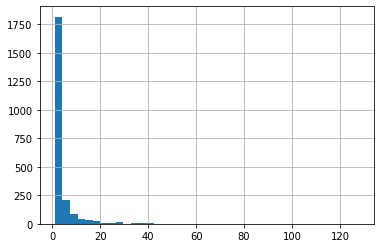

In [660]:
df_combined['Counts'].hist(bins=40)

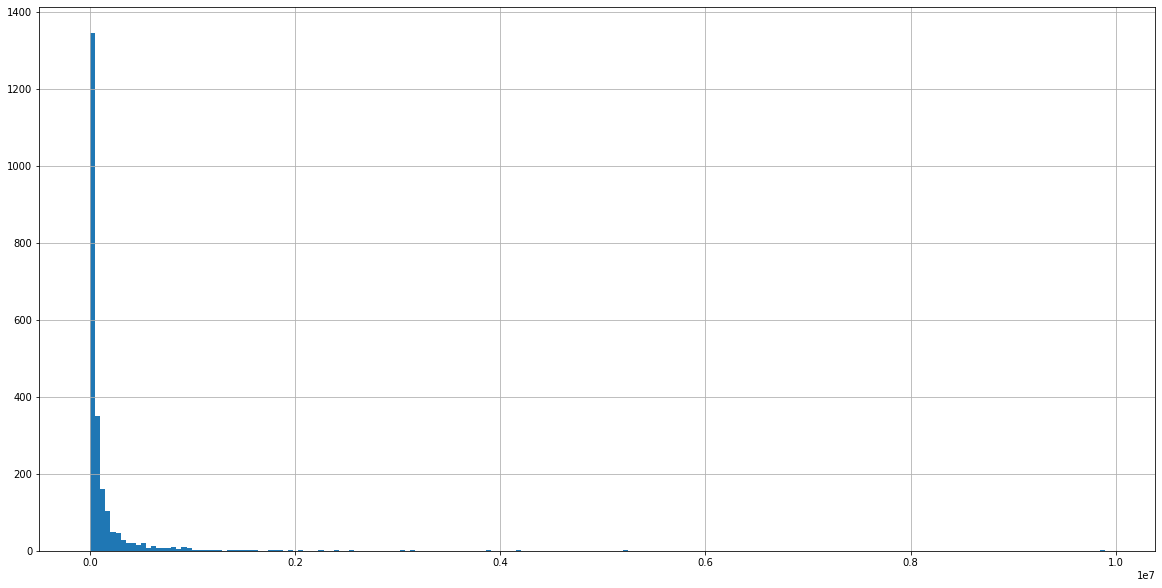

In [661]:
df_combined['population'].hist(bins=200,figsize=(20,10))

In [662]:
i=1
while i>=0:
    print('\nQuantile:',i,'\nPopulation',df_combined['population'].quantile(i))
    i-=0.01


Quantile: 1 
Population 9893481.0

Quantile: 0.99 
Population 1504356.6000000043

Quantile: 0.98 
Population 948043.1599999998

Quantile: 0.97 
Population 811073.0400000002

Quantile: 0.96 
Population 669485.7199999979

Quantile: 0.95 
Population 542307.2

Quantile: 0.94 
Population 473698.40000000014

Quantile: 0.9299999999999999 
Population 418052.6400000008

Quantile: 0.9199999999999999 
Population 357747.1599999999

Quantile: 0.9099999999999999 
Population 314687.03999999893

Quantile: 0.8999999999999999 
Population 282990.8

Quantile: 0.8899999999999999 
Population 261779.15999999963

Quantile: 0.8799999999999999 
Population 234152.39999999988

Quantile: 0.8699999999999999 
Population 207883.28

Quantile: 0.8599999999999999 
Population 194995.08

Quantile: 0.8499999999999999 
Population 179746.39999999973

Quantile: 0.8399999999999999 
Population 166896.91999999995

Quantile: 0.8299999999999998 
Population 160082.31999999995

Quantile: 0.8199999999999998 
Population 151428.52

Qu

In [663]:
i=1
while i>=0:
    print('\nQuantile:',i,'\nCounts',df_combined['Counts'].quantile(i))
    i-=0.01
#df_combined['Counts'].quantile(0.5)     #.hist(bins=50,figsize=(20,10))


Quantile: 1 
Counts 128.0

Quantile: 0.99 
Counts 29.0

Quantile: 0.98 
Counts 21.0

Quantile: 0.97 
Counts 18.0

Quantile: 0.96 
Counts 15.0

Quantile: 0.95 
Counts 13.0

Quantile: 0.94 
Counts 11.0

Quantile: 0.9299999999999999 
Counts 10.0

Quantile: 0.9199999999999999 
Counts 9.0

Quantile: 0.9099999999999999 
Counts 8.0

Quantile: 0.8999999999999999 
Counts 8.0

Quantile: 0.8899999999999999 
Counts 7.0

Quantile: 0.8799999999999999 
Counts 7.0

Quantile: 0.8699999999999999 
Counts 6.0

Quantile: 0.8599999999999999 
Counts 6.0

Quantile: 0.8499999999999999 
Counts 6.0

Quantile: 0.8399999999999999 
Counts 5.0

Quantile: 0.8299999999999998 
Counts 5.0

Quantile: 0.8199999999999998 
Counts 5.0

Quantile: 0.8099999999999998 
Counts 5.0

Quantile: 0.7999999999999998 
Counts 4.0

Quantile: 0.7899999999999998 
Counts 4.0

Quantile: 0.7799999999999998 
Counts 4.0

Quantile: 0.7699999999999998 
Counts 4.0

Quantile: 0.7599999999999998 
Counts 4.0

Quantile: 0.7499999999999998 
Counts 4.0


Excluding the 10% largest and 10% smallest counties. The reason for this counties with a very large population tend to be diverse socioeconomically data by county does not give us the granularity necessary for analysis. Also very small counties are often in economic distress.

In [666]:
#df_combined=df_combined[(df_combined['Counts']>=1) & (df_combined['population']<=200000)].sort_values(by='counts_per_capita',ascending=False)
df_combined=df_combined[(df_combined['population']>=9306) & (df_combined['population']<=282991)].sort_values(by='counts_per_capita',ascending=False)

In [667]:
df_combined.corr()

,per capita income,median household income,median family income,population,number of households,Counts,website_count,OrganicYN,BakedgoodsYN,CheeseYN,...,CoffeeYN,BeansYN,FruitsYN,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,counts_per_capita
per capita income,1.000000,0.905287,0.930597,0.318023,0.340207,0.357677,0.372553,0.318766,0.370939,0.310181,...,0.294914,0.126547,0.317612,0.184764,0.311229,0.296733,0.301841,0.200175,0.204338,0.036949
median household income,0.905287,1.000000,0.966742,0.321167,0.316014,0.296445,0.313134,0.240187,0.306369,0.231088,...,0.230824,0.066292,0.254521,0.118497,0.235708,0.227229,0.258615,0.129117,0.145535,-0.039275
median family income,0.930597,0.966742,1.000000,0.337537,0.342281,0.336107,0.352461,0.285267,0.346418,0.263582,...,0.265249,0.092917,0.292908,0.157147,0.271832,0.264737,0.289461,0.160055,0.178238,-0.024553
population,0.318023,0.321167,0.337537,1.000000,0.994012,0.538261,0.568021,0.402098,0.485717,0.465607,...,0.487687,0.269217,0.486961,0.289057,0.411290,0.361649,0.408891,0.230724,0.245668,-0.407895
number of households,0.340207,0.316014,0.342281,0.994012,1.000000,0.559901,0.586670,0.420693,0.508940,0.489111,...,0.502314,0.282500,0.507483,0.302613,0.430017,0.379498,0.424963,0.246576,0.259245,-0.393073
Counts,0.357677,0.296445,0.336107,0.538261,0.559901,1.000000,0.836050,0.709932,0.839709,0.730475,...,0.661280,0.401726,0.804100,0.371106,0.583161,0.612715,0.464600,0.382412,0.458266,0.255689
website_count,0.372553,0.313134,0.352461,0.568021,0.586670,0.836050,1.000000,0.732058,0.827393,0.767846,...,0.705817,0.446416,0.812553,0.408840,0.630314,0.629853,0.498936,0.400127,0.486378,0.102808
OrganicYN,0.318766,0.240187,0.285267,0.402098,0.420693,0.709932,0.732058,1.000000,0.759358,0.751660,...,0.668184,0.480140,0.729019,0.446441,0.632766,0.663256,0.469980,0.461905,0.543957,0.114096
BakedgoodsYN,0.370939,0.306369,0.346418,0.485717,0.508940,0.839709,0.827393,0.759358,1.000000,0.811352,...,0.722325,0.458533,0.909860,0.409352,0.637633,0.658481,0.551558,0.379440,0.546053,0.170751
CheeseYN,0.310181,0.231088,0.263582,0.465607,0.489111,0.730475,0.767846,0.751660,0.811352,1.000000,...,0.734174,0.493717,0.779050,0.439779,0.668539,0.672169,0.547199,0.444579,0.545266,0.071572


In [668]:
df_combined.columns.values

array(['county', 'State', 'per capita income', 'median household income',
       'median family income', 'population', 'number of households',
       'County_State', 'Counts', 'website_count', 'OrganicYN',
       'BakedgoodsYN', 'CheeseYN', 'CraftsYN', 'FlowersYN', 'EggsYN',
       'SeafoodYN', 'HerbsYN', 'VegetablesYN', 'HoneyYN', 'JamsYN',
       'MapleYN', 'MeatYN', 'NurseryYN', 'NutsYN', 'PlantsYN',
       'PoultryYN', 'PreparedYN', 'SoapYN', 'TreesYN', 'WineYN',
       'CoffeeYN', 'BeansYN', 'FruitsYN', 'GrainsYN', 'JuicesYN',
       'MushroomsYN', 'PetFoodYN', 'TofuYN', 'WildHarvestedYN',
       'counts_per_capita'], dtype=object)

In [669]:
df_features=df_combined[['Counts', 'website_count', 'OrganicYN','BakedgoodsYN', 'CheeseYN', 'CraftsYN', 'FlowersYN', 'EggsYN','SeafoodYN', 'HerbsYN', 'VegetablesYN', 'HoneyYN', 'JamsYN','MapleYN', 'MeatYN', 'NurseryYN', 'NutsYN', 'PlantsYN','PoultryYN', 'PreparedYN', 'SoapYN', 'TreesYN', 'WineYN','CoffeeYN', 'BeansYN', 'FruitsYN', 'GrainsYN', 'JuicesYN','MushroomsYN', 'PetFoodYN', 'TofuYN', 'WildHarvestedYN','counts_per_capita','per capita income', 'median household income','median family income']].copy(deep=True)  #'population', 'number of households', 

In [670]:
df_features.head()

,Counts,website_count,OrganicYN,BakedgoodsYN,CheeseYN,CraftsYN,FlowersYN,EggsYN,SeafoodYN,HerbsYN,...,GrainsYN,JuicesYN,MushroomsYN,PetFoodYN,TofuYN,WildHarvestedYN,counts_per_capita,per capita income,median household income,median family income
958,5,4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.523013,24286.0,46429.0,55582.0
1268,4,1,0.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.370885,22719.0,37189.0,45424.0
255,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.368630,30531.0,53309.0,64313.0
1896,4,2,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.350877,19188.0,32881.0,39650.0
829,6,2,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.333519,25074.0,47494.0,57348.0


In [671]:
X=df_features[['Counts', 'website_count', 'OrganicYN','BakedgoodsYN', 'CheeseYN', 'CraftsYN', 'FlowersYN', 'EggsYN','SeafoodYN', 'HerbsYN', 'VegetablesYN', 'HoneyYN', 'JamsYN','MapleYN', 'MeatYN', 'NurseryYN', 'NutsYN', 'PlantsYN','PoultryYN', 'PreparedYN', 'SoapYN', 'TreesYN', 'WineYN','CoffeeYN', 'BeansYN', 'FruitsYN', 'GrainsYN', 'JuicesYN','MushroomsYN', 'PetFoodYN', 'TofuYN', 'WildHarvestedYN','counts_per_capita']].copy(deep=True)  #'population', 'number of households', 

In [672]:
scaler=StandardScaler()

In [673]:
X=scaler.fit_transform(X)

/home/user-1131/venv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/user-1131/venv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [674]:
pca = PCA(n_components=4)

In [675]:
features_principal_components=pca.fit_transform(X)

In [676]:
principal_components=pd.DataFrame(data=features_principal_components,columns = ['principal component 1', 'principal component 2', 'principal component 3','principal_component 4'])

In [677]:
principal_components.head()

,principal component 1,principal component 2,principal component 3,principal_component 4
0,-1.636247,-2.909279,6.571280,3.841326
1,0.264388,-1.072810,5.013108,2.139613
2,-2.965083,-1.385522,4.566527,2.668918
3,1.582743,-4.317806,2.310365,4.408187
4,-0.830751,-1.741846,4.129270,2.178240


In [678]:
pca.explained_variance_ratio_

array([0.62945887, 0.05748196, 0.03244303, 0.02883709])

In [679]:
y=df_features[['per capita income']]

In [680]:
from sklearn.model_selection import train_test_split
pca_train, pca_test, y_train, y_test = train_test_split(principal_components, y, test_size=0.2, random_state=0)

In [681]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()

In [682]:
regressor.fit(pca_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [683]:
y_pred=regressor.predict(pca_test)

In [684]:
regressor.coef_

array([[ 445.74632023,   88.53336312,  -90.82115052, -427.88298317]])

In [685]:
y_test

,per capita income
1536,21343.0
1379,22168.0
1376,22191.0
523,27058.0
95,35425.0
...,...
589,26584.0
1499,21520.0
1057,23779.0
881,24702.0


In [686]:
y_pred

array([[21653.12648473],
       [31831.43892419],
       [23077.60413628],
       [23957.15611409],
       [24574.47460643],
       [24084.30021987],
       [21511.57367053],
       [21894.59494286],
       [24819.91806097],
       [22429.46046869],
       [22759.28705276],
       [22777.4299002 ],
       [23950.48826287],
       [23032.13842846],
       [22309.92891416],
       [21646.09256402],
       [21512.15200859],
       [21983.4739037 ],
       [22084.2077068 ],
       [22153.35775949],
       [28542.79920725],
       [22043.66070981],
       [25563.31496662],
       [21664.13091829],
       [21886.11715686],
       [22722.30933275],
       [21798.84365613],
       [22020.74683123],
       [21814.68613773],
       [23241.22485053],
       [22414.58808391],
       [22787.55871347],
       [24385.15235642],
       [28581.46617253],
       [22535.9690682 ],
       [24220.83613253],
       [21911.37734758],
       [23915.49268871],
       [35890.62764902],
       [26088.98462091],


In [687]:
per_capita_income_predicted=pd.DataFrame(y_pred)
per_capita_income_predicted.head()

,0
0,21653.126485
1,31831.438924
2,23077.604136
3,23957.156114
4,24574.474606


In [688]:
df=y_test.copy(deep=True)
df.head()

,per capita income
1536,21343.0
1379,22168.0
1376,22191.0
523,27058.0
95,35425.0


In [689]:
df['per capita income - predicted']=y_pred
df.head(100)

,per capita income,per capita income - predicted
1536,21343.0,21653.126485
1379,22168.0,31831.438924
1376,22191.0,23077.604136
523,27058.0,23957.156114
95,35425.0,24574.474606
...,...,...
408,28086.0,21041.903653
740,25582.0,21774.464179
545,26920.0,22049.821357
1167,23213.0,22726.079778


In [690]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(df['per capita income'].values, df['per capita income - predicted'].values))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared:',metrics.r2_score(y_test,y_pred))

Mean Absolute Error: 3351.689342329537
Mean Squared Error: 22374650.047703873
Root Mean Squared Error: 4730.184990854361
R-squared: 0.09763665420363266


It's evident that the problem is not quite amenable to linear regression.

In the next section we'll attempt clustering the counties to see how clusters relate to per capita income.

In [691]:
km=KMeans(n_clusters=3, init='k-means++', n_init=100, max_iter=1000,tol=1e-05, random_state=0)

In [692]:
y_km=km.fit_predict(principal_components)

In [693]:
principal_components['centroid']=y_km

In [694]:
principal_components['per capita income']=y.values

In [695]:
principal_components.head()

,principal component 1,principal component 2,principal component 3,principal_component 4,centroid,per capita income
0,-1.636247,-2.909279,6.571280,3.841326,0,24286.0
1,0.264388,-1.072810,5.013108,2.139613,0,22719.0
2,-2.965083,-1.385522,4.566527,2.668918,0,30531.0
3,1.582743,-4.317806,2.310365,4.408187,1,19188.0
4,-0.830751,-1.741846,4.129270,2.178240,0,25074.0


In [696]:
principal_components.groupby(['centroid']).median()

,principal component 1,principal component 2,principal component 3,principal_component 4,per capita income
centroid,,,,,
0,-1.991224,0.130913,-0.050500,-0.104570,21909.0
1,3.290280,-0.424599,-0.293514,-0.151632,25183.5
2,16.059785,0.116871,0.255440,-0.602443,29377.0


In [697]:
principal_components.groupby(['centroid']).std()

,principal component 1,principal component 2,principal component 3,principal_component 4,per capita income
centroid,,,,,
0,1.323491,0.733163,0.785005,0.645834,4840.507858
1,2.629697,2.059175,1.347594,1.368475,4838.129951
2,7.214609,4.312229,2.634834,2.876720,7423.019128


In [698]:
principal_components.corr()

,principal component 1,principal component 2,principal component 3,principal_component 4,centroid,per capita income
principal component 1,1.000000e+00,1.301897e-17,-3.668214e-17,2.963232e-16,0.850908,0.375422
principal component 2,1.301897e-17,1.000000e+00,2.749667e-16,1.251336e-16,-0.039055,0.009590
principal component 3,-3.668214e-17,2.749667e-16,1.000000e+00,9.186123e-16,-0.014982,-0.002642
principal_component 4,2.963232e-16,1.251336e-16,9.186123e-16,1.000000e+00,-0.011035,-0.063760
centroid,8.509081e-01,-3.905462e-02,-1.498224e-02,-1.103487e-02,1.000000,0.356947
per capita income,3.754216e-01,9.590063e-03,-2.641576e-03,-6.375986e-02,0.356947,1.000000


Let's plot a boxplot to visualize income range for each distribution.

/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


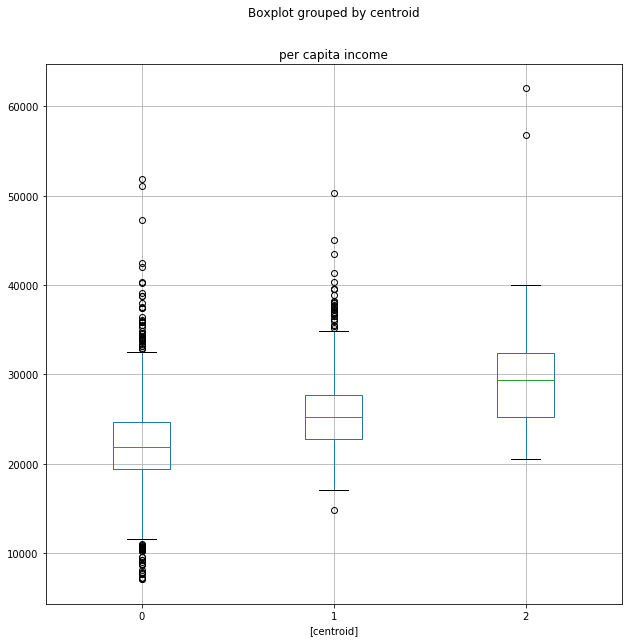

In [699]:
income_by_cluster=principal_components.boxplot(column=['per capita income'],by=['centroid'],figsize=(10,10))

Let's perform one-way ANOVA to verify if differences are statistically significant.

In [700]:
import scipy.stats as stats

stats.f_oneway(principal_components['per capita income'][principal_components['centroid'] == 0],
               principal_components['per capita income'][principal_components['centroid'] == 1],
               principal_components['per capita income'][principal_components['centroid'] == 2])
               #principal_components['per capita income'][principal_components['centroid'] == 3])
               #principal_components['per capita income'][principal_components['centroid'] == 4])

F_onewayResult(statistic=132.71820305720072, pvalue=1.6262690319935407e-54)

In [701]:
import researchpy as rp

rp.summary_cont(principal_components['per capita income'].groupby(principal_components['centroid']))

,N,Mean,SD,SE,95% Conf.,Interval
centroid,,,,,,
0,1363,22257.4453,4840.5079,131.1122,22000.2416,22514.6490
1,402,25843.8010,4838.1300,241.3040,25369.4221,26318.1799
2,50,30176.2600,7423.0191,1049.7734,28066.6613,32285.8587


Tukey Honestly Significant Difference test to pair-wise verify statistical significance.

In [702]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(principal_components['per capita income'],principal_components['centroid'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,3586.3557,0.001,2930.3353,4242.376,True
0,2,7918.8147,0.001,6254.4669,9583.1624,True
1,2,4332.459,0.001,2599.1455,6065.7725,True


In [703]:
principal_components.head()

,principal component 1,principal component 2,principal component 3,principal_component 4,centroid,per capita income
0,-1.636247,-2.909279,6.571280,3.841326,0,24286.0
1,0.264388,-1.072810,5.013108,2.139613,0,22719.0
2,-2.965083,-1.385522,4.566527,2.668918,0,30531.0
3,1.582743,-4.317806,2.310365,4.408187,1,19188.0
4,-0.830751,-1.741846,4.129270,2.178240,0,25074.0


In [704]:
df_combined['PreparedYN']

958     0.0
1268    0.0
255     0.0
1896    1.0
829     0.0
       ... 
1462    0.0
1631    0.0
1187    1.0
2212    1.0
545     0.0
Name: PreparedYN, Length: 1815, dtype: float64

In [705]:
principal_components['Population']=df_combined['population'].values

In [706]:
principal_components['PreparedYN per Farmers Market']=(df_combined['PreparedYN']/df_combined['Counts']).values

In [707]:
principal_components['CoffeeYN per Farmers Market']=(df_combined['CoffeeYN']/df_combined['Counts']).values

In [708]:
principal_components['OrganicYN per Farmers Market']=(df_combined['OrganicYN']/df_combined['Counts']).values

In [709]:
principal_components['SeafoodYN per Farmers Market']=(df_combined['SeafoodYN']/df_combined['Counts']).values

In [710]:
principal_components['Nurseries per Farmers Market']=(df_combined['NurseryYN']/df_combined['Counts']).values

In [711]:
principal_components['Baked_Goods per Farmers Market']=(df_combined['BakedgoodsYN']/df_combined['Counts']).values

In [712]:
principal_components['Website_count per Farmers Market']=(df_combined['website_count']/df_combined['Counts']).values

In [713]:
principal_components['Counts']=df_combined['Counts'].values

In [714]:
principal_components['Counts per Capita']=df_combined['counts_per_capita'].values

In [715]:
principal_components['Median Family Income']=df_combined['median family income'].values

In [716]:
principal_components['Median Household Income']=df_combined['median household income'].values

In [717]:
principal_components.head()

,principal component 1,principal component 2,principal component 3,principal_component 4,centroid,per capita income,Population,PreparedYN per Farmers Market,CoffeeYN per Farmers Market,OrganicYN per Farmers Market,SeafoodYN per Farmers Market,Nurseries per Farmers Market,Baked_Goods per Farmers Market,Website_count per Farmers Market,Counts,Counts per Capita,Median Family Income,Median Household Income
0,-1.636247,-2.909279,6.571280,3.841326,0,24286.0,9560.0,0.00,0.00,0.0,0.000000,0.00,0.600000,0.800000,5,0.523013,55582.0,46429.0
1,0.264388,-1.072810,5.013108,2.139613,0,22719.0,10785.0,0.00,0.25,0.0,0.250000,0.00,0.500000,0.250000,4,0.370885,45424.0,37189.0
2,-2.965083,-1.385522,4.566527,2.668918,0,30531.0,10851.0,0.00,0.00,0.0,0.000000,0.00,0.000000,0.500000,4,0.368630,64313.0,53309.0
3,1.582743,-4.317806,2.310365,4.408187,1,19188.0,11400.0,0.25,0.00,0.0,0.000000,0.25,0.750000,0.500000,4,0.350877,39650.0,32881.0
4,-0.830751,-1.741846,4.129270,2.178240,0,25074.0,17990.0,0.00,0.00,0.0,0.166667,0.00,0.166667,0.333333,6,0.333519,57348.0,47494.0


/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


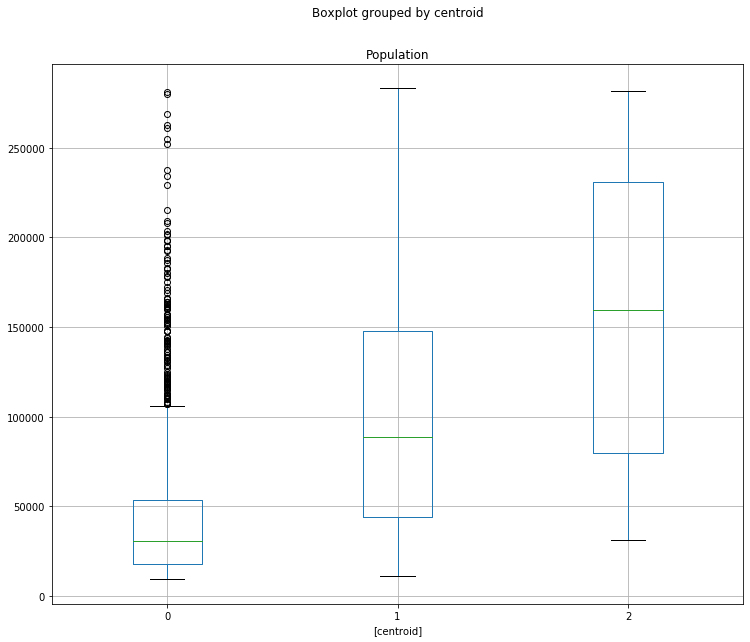

In [718]:
County_Population=principal_components.boxplot(column=['Population'],by=['centroid'],figsize=(12,10))

/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


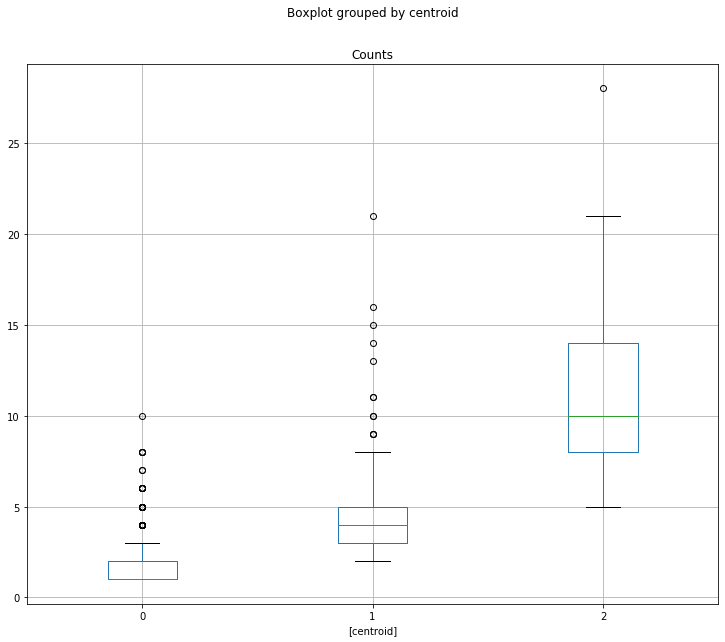

In [719]:
Number_of_Farmers_Market=principal_components.boxplot(column=['Counts'],by=['centroid'],figsize=(12,10))

/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


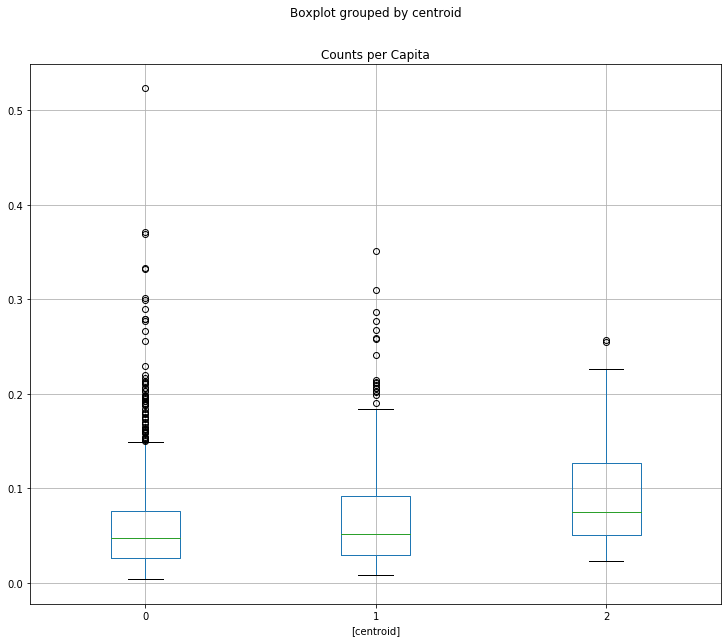

In [720]:
Number_of_Farmers_Market=principal_components.boxplot(column=['Counts per Capita'],by=['centroid'],figsize=(12,10))

In [721]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(principal_components['Counts per Capita'],principal_components['centroid'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.0103,0.001,0.0037,0.0169,True
0,2,0.0365,0.001,0.0196,0.0533,True
1,2,0.0262,0.0014,0.0086,0.0437,True


/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diff

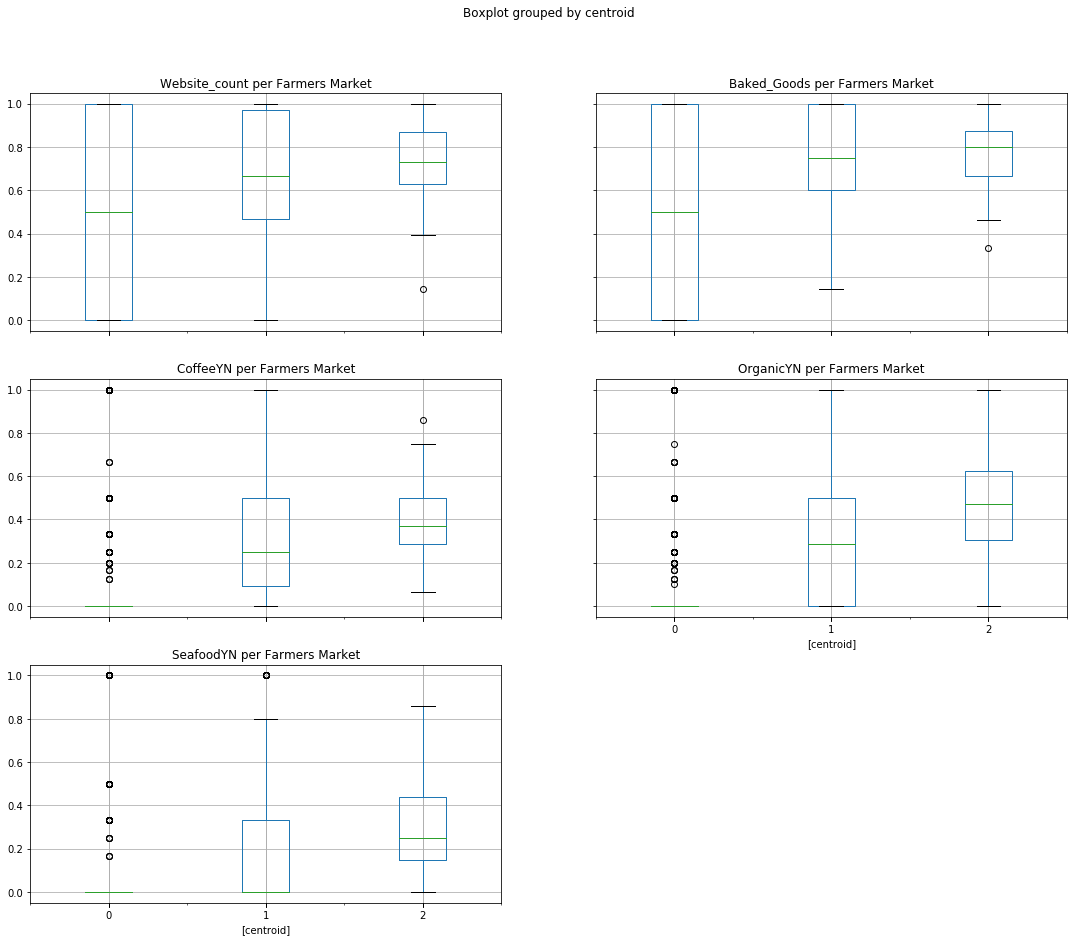

In [722]:
Farmers_Market_Availability=principal_components.boxplot(column=['Website_count per Farmers Market','Baked_Goods per Farmers Market','CoffeeYN per Farmers Market','OrganicYN per Farmers Market','SeafoodYN per Farmers Market'],by=['centroid'],figsize=(18,15))

In [723]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(principal_components['OrganicYN per Farmers Market'],principal_components['centroid'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.1542,0.001,0.1133,0.1951,True
0,2,0.3279,0.001,0.2241,0.4317,True
1,2,0.1737,0.001,0.0656,0.2818,True


In [724]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(principal_components['CoffeeYN per Farmers Market'],principal_components['centroid'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.1457,0.001,0.1028,0.1886,True
0,2,0.2311,0.001,0.1222,0.3399,True
1,2,0.0854,0.1812,-0.028,0.1988,False


In [725]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(principal_components['Median Family Income'],principal_components['centroid'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,8978.8436,0.001,7289.0621,10668.6251,True
0,2,17427.1342,0.001,13140.0965,21714.1719,True
1,2,8448.2906,0.001,3983.6106,12912.9707,True


/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


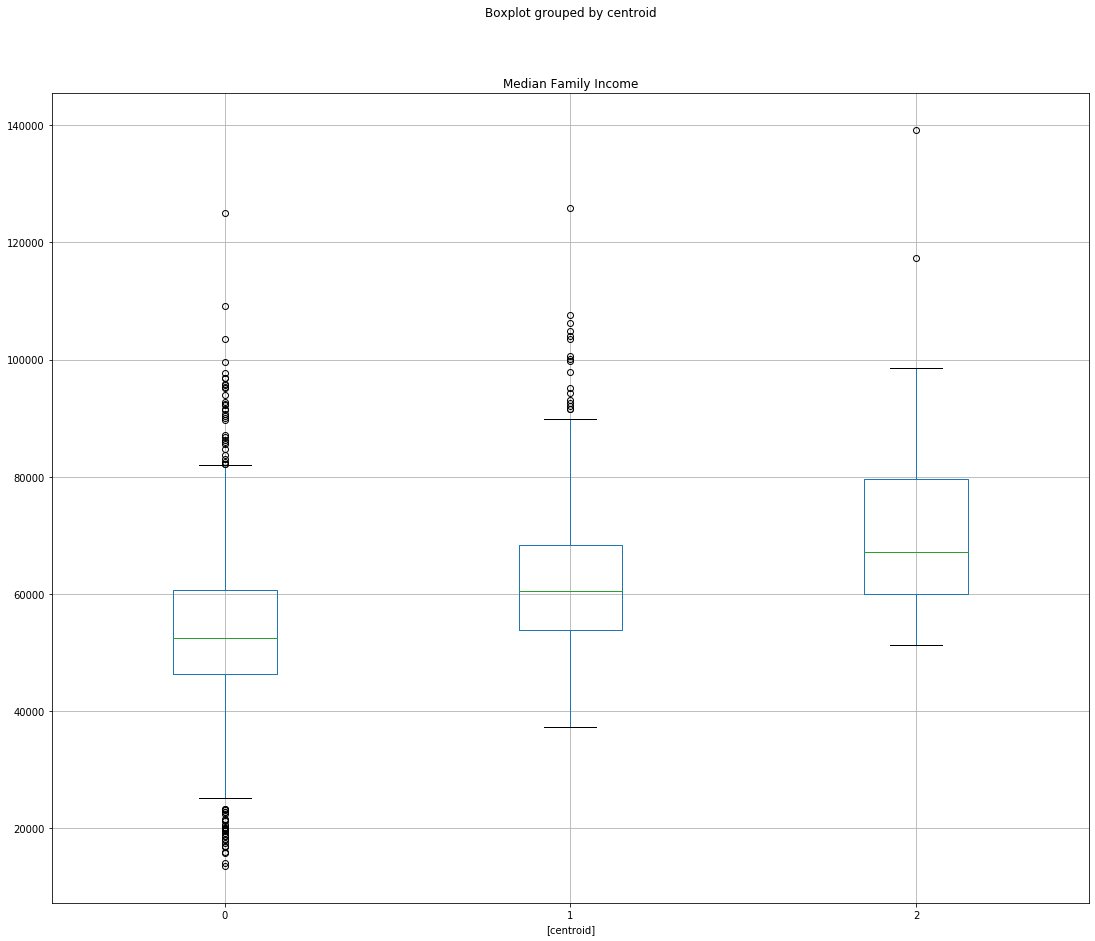

In [726]:
Farmers_Market_Availability=principal_components.boxplot(column=['Median Family Income'],by=['centroid'],figsize=(18,15))

In [727]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(principal_components['Median Household Income'],principal_components['centroid'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,7039.1053,0.001,5548.8178,8529.3928,True
0,2,12673.6877,0.001,8892.7736,16454.6018,True
1,2,5634.5824,0.0023,1696.9982,9572.1665,True


/home/user-1131/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


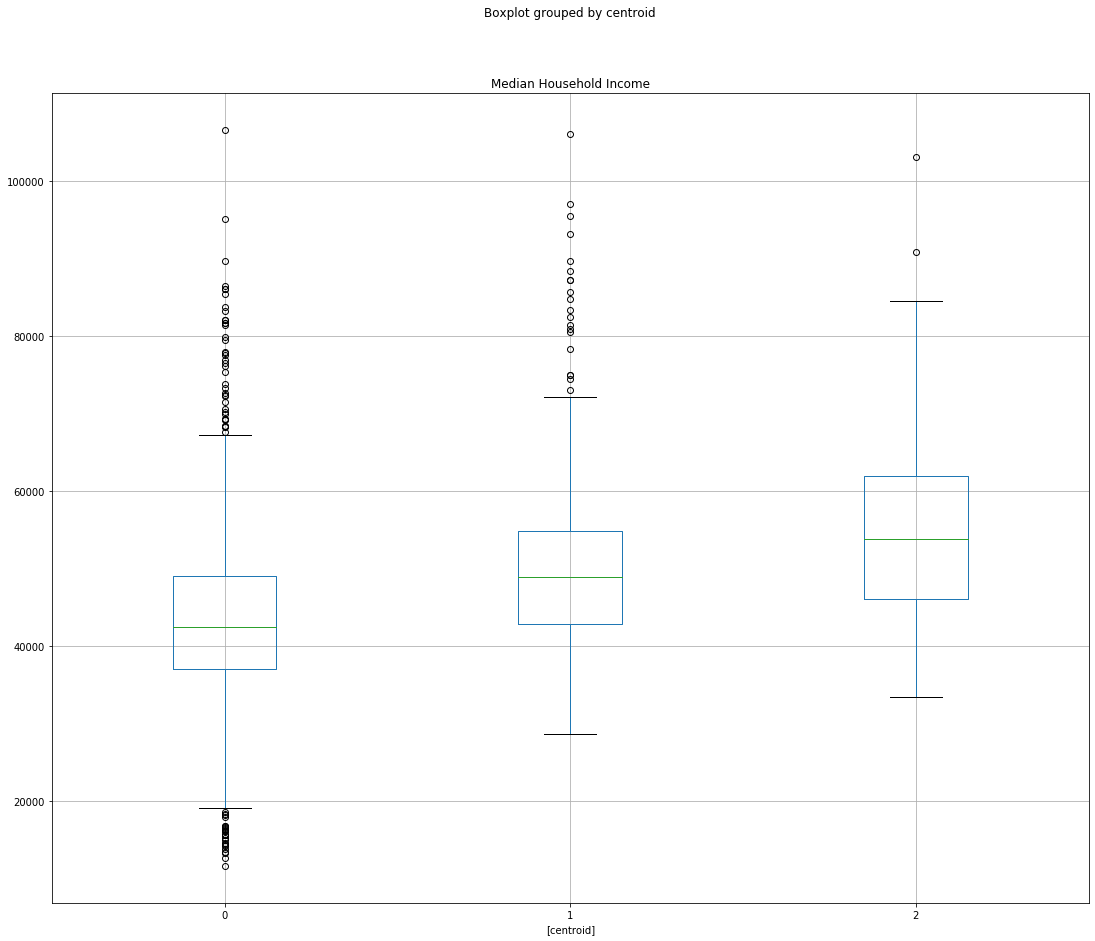

In [728]:
Farmers_Market_Availability=principal_components.boxplot(column=['Median Household Income'],by=['centroid'],figsize=(18,15))